# CS5228 Project - Task 3 Open Task

This part is divided into two sub-tasks:
1.	Using the car resale transactions data, we do an in-depth analysis of past transactions by fetching additional data from SgCarMart site to identify profitable and non-profitable listings. 
2.	We also analyzed the interest of Singapore car-buyers in eco-friendly cars. 


In [1]:
import sys

sys.path.append("..")

In [2]:
import pandas as pd

from src.transformers import *
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import loguniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    BaggingRegressor,
)
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Load processed dataset from Task1

In [3]:
train = pd.read_csv("../data/processed/train.csv", sep=",")
test = pd.read_csv("../data/processed/test.csv", sep=",")

1. [Analyzing most (un)-profitable cars for SgCarMart](#task1)

2. [Analyzing Eco Friendly Cars](#task2)

3. [Scarpper to fetch the status and new prices of the listing-ids](#scrapper)


<a id='task1'></a>
### 1. Analyzing most (un)-profitable cars for SgCarMart

The purpose of this task is to do an in-depth analysis of past transactions to find out most profitable and non-profitable cars for SgCarMart. We assume that SgCarMart’s revenue comes from transactions buy/sell that takes place on their website. A profitable listing could be defined as the one whose time from listing to transaction is less. And a listing which is there for a long period of time and unable to sell would be considered as a non-profitable listing/car. To identify the factors that lead to a quick transaction, we should analyze the user behavior and how a user perceives any listing. In general, a listing will have high value if it has a higher perceived value for the buyer.

In [4]:
train_price_path = "../data/other/current_train_prices.csv"
p = pd.read_csv(train_price_path, header=None)
train["cp"] = p[1]
train["sold"] = train.cp == "N.A" * 1

### Identifying the most fast-selling car models 

We analyzed all the car models which have been sold recently and identified the models which have been sold more than 80 percent of the total available listings of that model. For. E.g., based on the plot, we can start recommending our users bmw-x1, Mercedes-benz-gla180, etc. cars which are selling fast and only a limited listings are available.

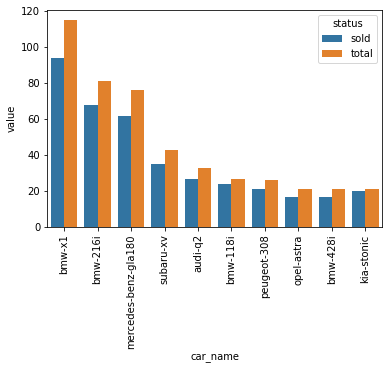

In [5]:
a = (
    train.groupby(["make", "model"])
    .agg({"sold": [np.sum], "listing_id": [np.size]})
    .reset_index()
    .sort_values(by=[("listing_id", "size")], ascending=False)
)
a.columns = ["make", "model", "sold", "total"]

a = a[(a.sold / a.total > 0.8) & (a.total > 20)]
a = pd.melt(a, id_vars=["make", "model"], var_name="status", value_name="value")
a["car_name"] = a.make + "-" + a.model

sns.barplot(data=a, x="car_name", y="value", hue="status")
_ = plt.xticks(rotation=90)

In [6]:
train.groupby(["make", "model"]).sum().reset_index()[
    ["sold", "make", "model"]
].sort_values(by=["sold"])

,sold,make,model
185,0,hafei,minz
487,0,nissan,nv100
335,0,maxus,g10
490,0,nissan,nv250
492,0,nissan,presage
...,...,...,...
289,246,kia,cerato
198,255,honda,civic
218,269,honda,vezel
370,278,mercedes-benz,amg


In [7]:
train.groupby(["make", "model"]).count().reset_index()[
    ["listing_id", "make", "model"]
].sort_values(by=["listing_id"])

,listing_id,make,model
0,1,alfa romeo,159
694,1,yutong,zk6100h
341,1,mazda,cx-7
340,1,mazda,cx-3
336,1,maxus,v80
...,...,...,...
289,353,kia,cerato
198,379,honda,civic
218,389,honda,vezel
618,477,toyota,corolla


### Analyzing low-selling cars and identifying possible reasons

Here, we analyzed one of the popular car models, Mercedes-Benz AMG and filtered out listings that have been manufactured in the same year and are similar to each other. We can observe that beyond the highlighted area that are many unsold cars and within the highlighted area most are sold. The unsold listings have been put with a higher price compared to other cars of the same model and hence, are not finding a buyer.

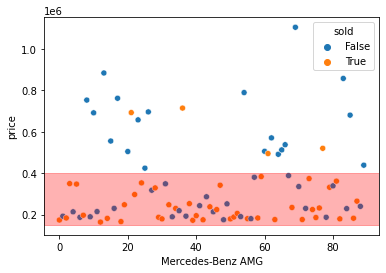

In [8]:
a = train[
    (train.make == "mercedes-benz")
    & (train.model == "amg")
    & (train.manufactured == 2019)
][["listing_id", "price", "sold"]]
a["id"] = list(range(a.shape[0]))
sns.scatterplot(data=a, x="id", y="price", hue="sold")
plt.axhspan(150000, 400000, color="red", alpha=0.3)
_ = plt.xlabel("Mercedes-Benz AMG")

### Models whose prices have dropped significantly recently

In [9]:
count = 0
for i in range(train.shape[0]):
    cp = train.iloc[i].cp
    price = train.iloc[i].price
    if f"{cp}".isdigit():
        cp = float(cp)
        if price - cp > 0:
            count = count + 1
            train.loc[i, "is_reduced"] = 1
            train.loc[i, "reduced_percent"] = cp / price

In [10]:
df = train

a = df[["listing_id", "make", "model", "reduced_percent", "price", "cp"]]
a[~a.reduced_percent.isna()].sort_values(by=["reduced_percent"])

,listing_id,make,model,reduced_percent,price,cp
1745,1005306,kia,cerato,0.225071,70200.0,15800
13041,1022998,jeep,patriot,0.262349,91100.0,23900
11626,992382,mazda,3,0.305040,75400.0,23000
2038,1002783,volvo,s60,0.324848,82500.0,26800
909,1021736,honda,fit,0.362827,93400.0,33888
...,...,...,...,...,...,...
1588,1024726,mercedes-benz,glc300,0.997931,247500.0,246988
11819,1007086,honda,civic,0.998587,212300.0,212000
15827,967688,mercedes-benz,e220,0.999132,244200.0,243988
1020,990992,mercedes-benz,amg,0.999524,209900.0,209800


<a id='task2'></a>
### 2. Analyzing Electric Vehicles 

We try and analyze the trend of electric cars over the past few years. We observed that the number of electric cars has increased significantly over the past few years. Last 2-3 years have been heavily impacted due to COVID-19 and the impact can be seen on all types of cars.

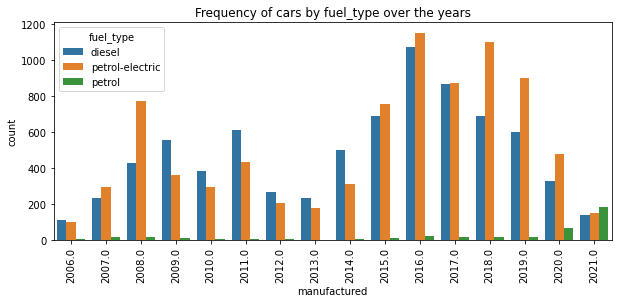

In [11]:
plt.figure(figsize=(10, 4))
temp = train
temp = temp.replace({"fuel_type": {"electric": "petrol-electric"}})
temp = temp.groupby("manufactured").count()["listing_id"].reset_index()
temp = temp[temp.listing_id > 100].manufactured.values
temp1 = train
temp1 = temp1.replace({"fuel_type": {"electric": "petrol-electric"}})
sns.countplot(
    x="manufactured", hue="fuel_type", data=temp1[temp1.manufactured.isin(temp)]
)
plt.xticks(rotation=90)
_ = plt.title("Frequency of cars by fuel_type over the years")

We looked at the electric cars produced by various brands. Currently, the electric/hibrid cars are only produced by a limited number brands.

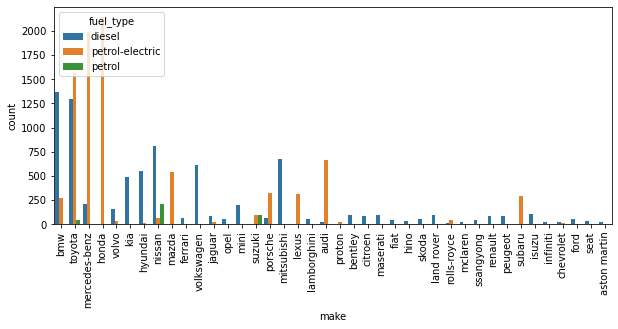

In [12]:
plt.figure(figsize=(10, 4))
temp = train[~train.fuel_type.isna()]
temp = temp.replace({"fuel_type": {"electric": "petrol-electric"}})
temp = temp.groupby("make").count()["listing_id"].reset_index()
temp = temp[temp.listing_id > 20].make.values
temp1 = train
temp1 = temp1.replace({"fuel_type": {"electric": "petrol-electric"}})
sns.countplot(x="make", hue="fuel_type", data=temp1[temp1.make.isin(temp)])
_ = plt.xticks(rotation=90)

We looked into various values corresponding to fuel_type. Electric cars due to their low maintenance and less wear and tear have a very low depreciation value compared to petrol and diesel cars. The deregistration value of these cars is also higher when comparing to its counterparts. These factors contribute heavily for the customer desire towards eco-friendly cars.

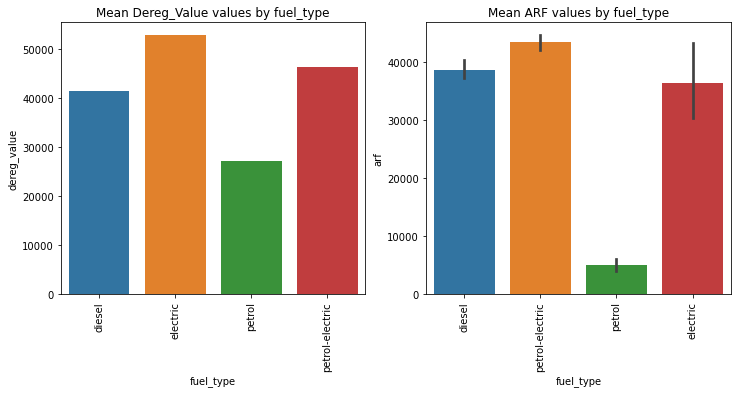

In [13]:
plt.figure(figsize=(12, 5))
df = train[train.manufactured >= 2014]
df = train.groupby(["fuel_type"]).mean().reset_index()
plt.subplot(1, 2, 1)
sns.barplot(data=df, x="fuel_type", y="dereg_value")
plt.title("Mean Dereg_Value values by fuel_type")
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
df = train
sns.barplot(data=df, x="fuel_type", y="arf")
plt.title("Mean ARF values by fuel_type")
_ = plt.xticks(rotation=90)

### Depreciation value by fuel_type

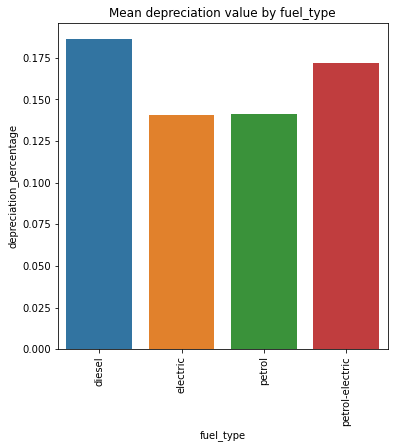

In [14]:
plt.figure(figsize=(13, 6))

df = train
df["depreciation_percentage"] = train.depreciation / train.price
df = df.groupby(["fuel_type"]).mean().reset_index()
plt.subplot(1, 2, 2)
sns.barplot(data=df, x="fuel_type", y="depreciation_percentage")
plt.title("Mean depreciation value by fuel_type")
_ = plt.xticks(rotation=90)

Electric cars more expensive than petrol and diesel cars
The average price of an electric vehicle is also on a higher side compared to petrol/diesel cars of similar configuration.

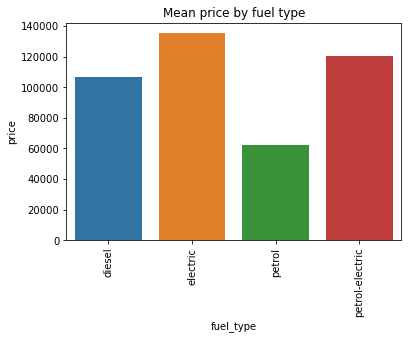

In [15]:
df = train.groupby(["fuel_type"]).mean().reset_index()

sns.barplot(data=df, x="fuel_type", y="price")
plt.xticks(rotation=90)
_ = plt.title("Mean price by fuel type")

<AxesSubplot:xlabel='price', ylabel='fuel_type'>

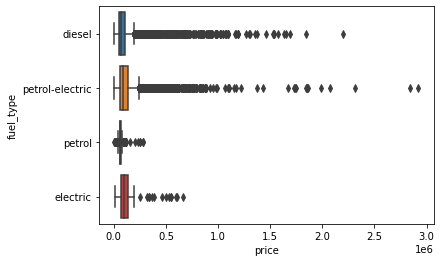

In [16]:
sns.boxplot(data=train, y="fuel_type", x="price")

<a id='scrapper'></a>
### 3. Scrapper to extract the status of existing listing-ids and change in price

Below cells are commented to avoid accidentally running them - uncomment if you're sure about it.

In [17]:
# import requests
# import pickle

# from bs4 import BeautifulSoup
# from difflib import SequenceMatcher



# def scrape_sgcarmart(listing_id):
#     print(f"scrape_sgcarmart - scraping sgcarmart for listing - {listing_id}")
#     response = requests.get(
#         f"https://www.sgcarmart.com/new_cars/newcars_listing.php?MOD={listing_id}"
#     )
#     try:
#         soup = BeautifulSoup(response.text, features="html.parser")
#         result = soup.select("div#listingcorner")
#     except AttributeError as e:
#         result = ""

#     return result

In [18]:
# car_list = {}
# for i in range(train.shape[0]):
#     if i % 500 == 0:
#         save_obj(car_list, f"car_price_{i}")
#         save_obj(car_list, f"car_price")
#         print(f"Iteration-{i}")
#     try:
#         search = train.loc[i, "make"] + " " + train.loc[i, "model"]
#         result = scrape_sgcarmart(search)
#         if search not in car_list:
#             car_list[search] = []
#         for j in range(20):
#             try:
#                 r = result[0]
#                 name = r.select(f"table:nth-of-type({j}) a strong")[0].text.strip()
#                 price = r.select(
#                     f"table:nth-of-type({j}) table table table td.font_bold"
#                 )[0].text.strip()
#                 car_list[search].append([name, price])
#             except Exception as e:
#                 pass
#     except Exception as e:
#         print(e)
#         car_list = load_obj("car_price")

In [19]:
# def similar(a, b):
#     return SequenceMatcher(None, a, b).ratio()


# def save_obj(obj, name):
#     with open("obj/" + name + ".pkl", "wb") as f:
#         pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


# def load_obj(name):
#     with open("obj/" + name + ".pkl", "rb") as f:
#         return pickle.load(f)


# full_dict = {}
# for i in range(1, 35):
#     try:
#         a = load_obj(f"car_price_{i*500}")
#         full_dict = full_dict | a
#     except Exception as e:
#         print(e)

# for i in range(0, train.shape[0]):
#     text = train.loc[i, "make"] + " " + train.loc[i, "model"]
#     if text in full_dict and len(full_dict[text]) > 0:
#         matches = full_dict[text]
#         temp_list = []
#         for match in matches:
#             temp_list.append([similar(text, match[0]), f"{match[1]}"])
#         temp = pd.DataFrame(temp_list)
#         temp = temp.sort_values(by=[0], ascending=False)
#         temp = temp[temp[1] != "POA"]
#         if temp.shape[0] == 0:
#             continue
#         l = []
#         for j in temp[1]:
#             v = j.split("$")[1]
#             v = v.replace(",", "")
#             l.append(v)
#         temp[1] = l
#         temp[1] = temp[1].str.replace(",", "")
#         temp[1] = pd.to_numeric(temp[1], errors="coerce")

#         price = temp.iloc[0:5, 1].mean()
#         train.loc[i, "new_price"] = price